In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import yfinance as yf
from sklearn.cluster import KMeans
from colorama import Fore, Style

import seaborn as sns
sns.set(style='darkgrid')
import plotly.graph_objects as go

import sys
sys.path.append('../src') 

from scipy.stats import norm
from scipy.optimize import minimize

In [2]:
from kneed import KneeLocator

def get_optimum_clusters(df, saturation_point=0.05):
    '''

    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers

    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    # knee = KneeLocator(range(1, size), wcss, curve='convex', direction='decreasing')
    # optimum_k = knee.knee

    optimum_clusters = k_models[optimum_k]

    return optimum_clusters

def identify_weak_support_resistance(data):
    # Initialize an empty list to store the labels (support, resistance, neither)
    labels = []

    # Iterate through the dataframe to identify weak support and weak resistance
    for i in range(len(data)):
        if i == 0 or i == len(data) - 1:
            # Edge cases where there's no previous or following day
            labels.append("neither")
        elif data['close'][i] < data['close'][i - 1] and data['close'][i] < data['close'][i + 1]:
            # Weak support condition
            labels.append("weak support")
        elif data['close'][i] > data['close'][i - 1] and data['close'][i] > data['close'][i + 1]:
            # Weak resistance condition
            labels.append("weak resistance")
        else:
            # Neither weak support nor weak resistance
            labels.append("neither")

    # Add the labels to a new column in the dataframe
    data['Support/Resistance'] = labels

    return data

In [3]:
import numpy as np
from scipy.optimize import fsolve

def break_point_solution_bb(stock_name):
    '''
    Solve for the break point solution price for breaking the current MA/BB
    stock_name: str
    '''
    df = yf.download(stock_name.upper(),
                 start=(datetime.today() - relativedelta(days=100)).strftime('%Y-%m-%d'),
                 end=datetime.today()
                 )
    df = df.reset_index()
    df.columns = df.columns.str.lower()
    df = df[['close']]
    
    # Define the expression whose roots we want to find
    # fsolve is not satisfying; provide analytical solution
    last_19day_price = df['close'][-20:-1]
    last_49day_price = df['close'][-50:-1]    

    a1 = np.sum(last_19day_price)
    a2 = np.sum(last_19day_price**2)
    p_ma = np.mean(last_19day_price)
    p_ubb = (562*a1 + np.sqrt((562*a1)**2 - 4*(5339*(99*a1**2-1600*a2))))/5339/2
    p_lbb = (562*a1 - np.sqrt((562*a1)**2 - 4*(5339*(99*a1**2-1600*a2))))/5339/2
    
    print('20MA break point:', p_ma.round(2))
    print('20MA Lower Bollinger Band break point:', p_lbb.round(2))
    print('20MA Upper Bollinger Band break point:', p_ubb.round(2))

    a1 = np.sum(last_49day_price)
    a2 = np.sum(last_49day_price**2)
    p_ma = np.mean(last_49day_price)
    p_ubb = (4177*a1 + np.sqrt((4177*a1)**2 - 4*(102336.5*(361.5*a1**2-15625*a2))))/102336.5/2
    p_lbb = (4177*a1 - np.sqrt((4177*a1)**2 - 4*(102336.5*(361.5*a1**2-15625*a2))))/102336.5/2
    
    print('50MA break point:', p_ma.round(2))
    print('50MA Lower Bollinger Band break point:', p_lbb.round(2))
    print('50MA Upper Bollinger Band break point:', p_ubb.round(2))

In [4]:
def plot_stock(stock_name,
               start=(datetime.today() - relativedelta(years=3)).strftime('%Y-%m-%d'),
               end=datetime.today(),
               figsize=(12, 9),
               interactive=False,
               return_result=False,
              ):
    '''
    Input:
    stock_name: str
    start: datetime
    end: datetime
    '''
    df = yf.download(stock_name.upper(),
                     start=start,
                     end=end)
    df = df.reset_index()
    df.columns = df.columns.str.lower()

    df['20 Day MA'] = df['close'].rolling(window=20).mean()
    df['20 Day STD'] = df['close'].rolling(window=20).std()
    df['Upper Band - 20MA'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band - 20MA'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    df['50 Day MA'] = df['close'].rolling(window=50).mean()
    df['50 Day STD'] = df['close'].rolling(window=50).std()
    df['Upper Band - 50MA'] = df['50 Day MA'] + (df['50 Day STD'] * 2.5)
    df['Lower Band - 50MA'] = df['50 Day MA'] - (df['50 Day STD'] * 2.5)
    
    close = df.iloc[-1]['close']
    print('* previous stock price closing', round(close,2))
    print("Latest 20 Day MA:", round(df['20 Day MA'].tolist()[-1], 2))
    print("Latest Lower Bollinger Band, 20MA:", round(df['Lower Band - 20MA'].tolist()[-1], 2))
    print("Latest Higher Bollinger Band, 20MA:", round(df['Upper Band - 20MA'].tolist()[-1], 2))
    print("Latest 50 Day MA:", round(df['50 Day MA'].tolist()[-1], 2))
    print("Latest Lower Bollinger Band, 50MA:", round(df['Lower Band - 50MA'].tolist()[-1], 2))
    print("Latest Higher Bollinger Band, 50MA:", round(df['Upper Band - 50MA'].tolist()[-1], 2))
    print()

    # Calculate RSI
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    latest_rsi = round(df['RSI'].tolist()[-1], 2)
    if latest_rsi > 70:
        print("Latest RSI:", Fore.RED + str(latest_rsi), Style.RESET_ALL)
    elif latest_rsi < 30:
        print("Latest RSI:", Fore.GREEN + str(latest_rsi), Style.RESET_ALL)
    else:
        print("Latest RSI:", latest_rsi, Style.RESET_ALL)    

    # Calculate MACD
    df['12 Day EMA'] = df['close'].ewm(span=12, adjust=False).mean()
    df['26 Day EMA'] = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['12 Day EMA'] - df['26 Day EMA']
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    latest_macd = round((df['MACD'] - df['MACD_signal']).tolist()[-1], 2)
    if latest_macd < 0:
        print("Latest MACD Divergence:", Fore.RED + str(latest_macd), Style.RESET_ALL)
    elif latest_macd > 0:
        print("Latest MACD Divergence:", Fore.GREEN + str(latest_macd), Style.RESET_ALL)
    else:
        print("Latest MACD Divergence:", Fore.BLACK + str(latest_macd), Style.RESET_ALL)
    
    break_point_solution_bb(stock_name)
    # df = identify_weak_support_resistance(df)
    
    # low_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak support'][['date',"close"]].set_index('date'))
    # low_centers = low_clusters.cluster_centers_
    # low_centers = np.sort(low_centers, axis=0)
    
    # high_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak resistance'][['date',"close"]].set_index('date'))
    # high_centers = high_clusters.cluster_centers_
    # high_centers = np.sort(high_centers, axis=0)
    
    # print('Supports')
    # print([low[0] for low in low_centers[:]])
    # print('Resistance')
    # print([high[0] for high in high_centers[:]])

    df_plot = df[df['date'] >= df['date'].min() + relativedelta(years=1)]
    if interactive:
        fig = go.Figure(layout=dict(width=figsize[0]*80, height=figsize[1]*80))
        
        fig.add_trace(go.Scatter(x=df_plot['date'], y=df_plot['close'], name='Daily Price'))
        fig.add_trace(go.Scatter(x=df_plot['date'], y=df_plot['50 Day MA'], mode='lines', line=dict(dash='dash'), name='50 Day MA'))
        fig.add_trace(go.Scatter(x=df_plot['date'], y=df_plot['Lower Band - 50MA'], mode='lines', line=dict(dash='dash'), name='Lower Band'))
        fig.add_trace(go.Scatter(x=df_plot['date'], y=df_plot['Upper Band - 50MA'], mode='lines', line=dict(dash='dash'), name='Upper Band', fill='tonexty', fillcolor='rgba(128,128,128,0.3)'))
        
        # for low in low_centers[:]:
        #     fig.add_trace(go.Scatter(x=df['date'], y=[low[0]]*len(df['date']), mode='lines', line=dict(color='green', dash='dash'), name='Support at ' + str(low[0])))
        # for high in high_centers[:]:
        #     fig.add_trace(go.Scatter(x=df['date'], y=[high[0]]*len(df['date']), mode='lines', line=dict(color='red', dash='dash'), name='Resistance at ' + str(high[0])))        
        fig.update_layout(title='Interactive Plot of Daily Stock Price for ' + stock_name,
                          xaxis_title='date',
                          yaxis_title='Daily Price',
                          hovermode='closest')
        
        # Add ability to select a single data point
        fig.update_traces(marker=dict(size=10, opacity=0.8),
                          selector=dict(mode='markers'))
        
        fig.show()
    else:
        # fig, ax = plt.subplots(figsize=figsize)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
        ax1.grid(True, alpha=0.5)
        ax1.plot(df_plot['date'], df_plot['close'], label='Daily Close Price')
        ax1.plot(df_plot['date'], df_plot['50 Day MA'], ls='--', label='50 Day Moving Average')
        ax1.plot(df_plot['date'], df_plot['Upper Band - 50MA'], ls='--', label='Upper Bollinger Band, 50MA')
        ax1.plot(df_plot['date'], df_plot['Lower Band - 50MA'], ls='--', label='Lower Bollinger Band, 50MA')
        ax1.fill_between(df_plot['date'], df_plot['Upper Band - 50MA'], df_plot['Lower Band - 50MA'], color='gray', alpha=0.3) # Fill the area between the bands
        ax1.set_title('Daily stock price for ' + stock_name.upper())
        ax1.legend()
            
        # Plot MACD and signal line, color bars based on MACD above/below signal line
        ax2.plot(df_plot['date'], df_plot['MACD'], label='MACD', color='red')
        ax2.plot(df_plot['date'], df_plot['MACD_signal'], label='Signal Line', linestyle='--', color='blue')
        bar_colors = ['green' if macd > signal else 'red' for macd, signal in zip(df_plot['MACD'], df_plot['MACD_signal'])]
        ax2.bar(df_plot['date'], df_plot['MACD'] - df_plot['MACD_signal'], width=1.5, align='center', color=bar_colors)        
        ax2.set_title('MACD')
        ax2.legend()
        fig.suptitle('MACD Analysis', fontsize=16)
        fig.subplots_adjust(hspace=0.05)  # Reduce vertical space between subplots
        plt.xticks(rotation=45) 
        
        plt.tight_layout()
        plt.show()
        # for low in low_centers[:]:
    	   #  ax.axhline(low[0], color='green', ls='--')
        # for high in high_centers[:]:
    	   #  ax.axhline(high[0], color='red', ls='--')

    if return_result:
        return df

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 458.94
Latest 20 Day MA: 473.82
Latest Lower Bollinger Band, 20MA: 459.58
Latest Higher Bollinger Band, 20MA: 488.06
Latest 50 Day MA: 469.35
Latest Lower Bollinger Band, 50MA: 449.92
Latest Higher Bollinger Band, 50MA: 488.78

Latest RSI: 23.48 
Latest MACD Divergence: -2.64 
[*********************100%%**********************]  1 of 1 completed
20MA break point: 474.6
20MA Lower Bollinger Band break point: 459.82
20MA Upper Bollinger Band break point: 489.39
50MA break point: 469.57
50MA Lower Bollinger Band break point: 448.71
50MA Upper Bollinger Band break point: 490.42


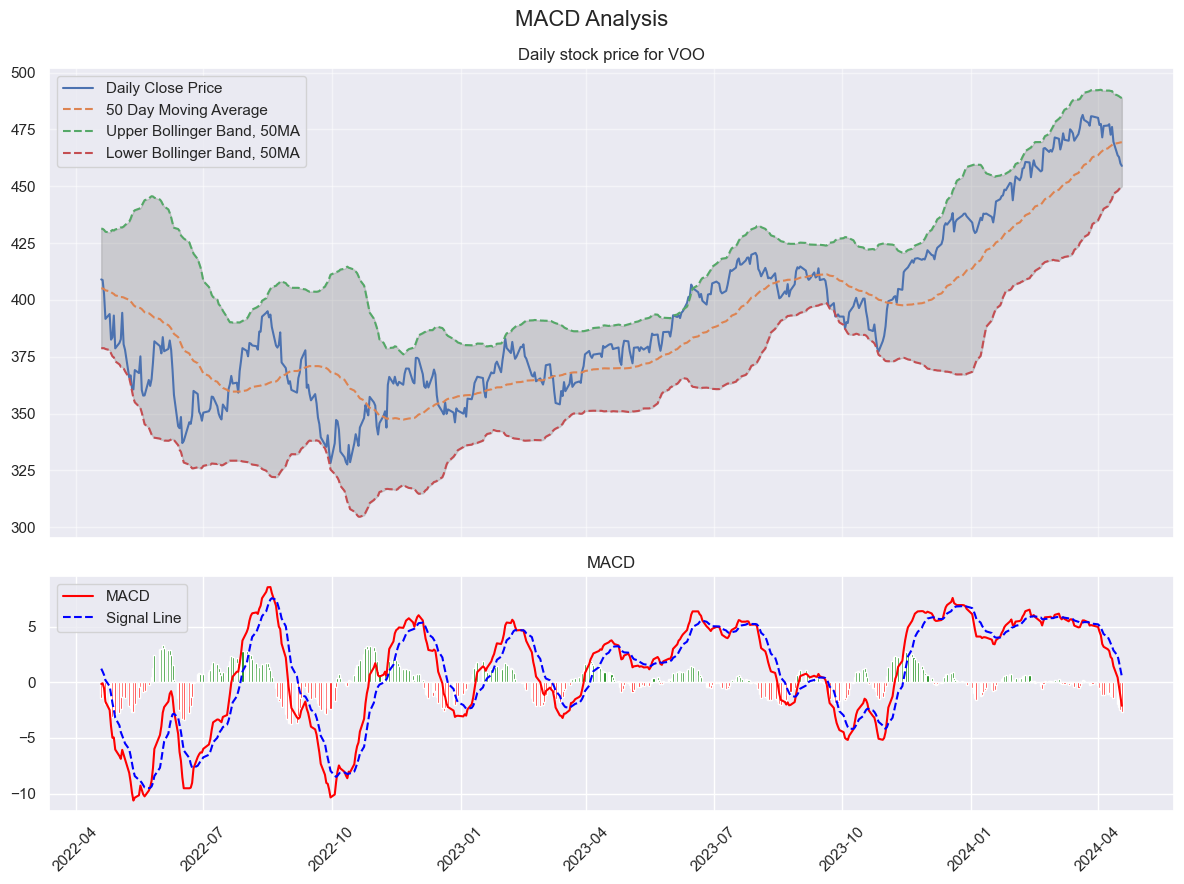

In [5]:
plot_stock('voo')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 174.26
Latest 20 Day MA: 180.83
Latest Lower Bollinger Band, 20MA: 175.27
Latest Higher Bollinger Band, 20MA: 186.38
Latest 50 Day MA: 180.21
Latest Lower Bollinger Band, 50MA: 174.2
Latest Higher Bollinger Band, 50MA: 186.22

Latest RSI: 30.48 
Latest MACD Divergence: -0.95 
[*********************100%%**********************]  1 of 1 completed
20MA break point: 181.17
20MA Lower Bollinger Band break point: 175.67
20MA Upper Bollinger Band break point: 186.67
50MA break point: 180.33
50MA Lower Bollinger Band break point: 174.19
50MA Upper Bollinger Band break point: 186.47


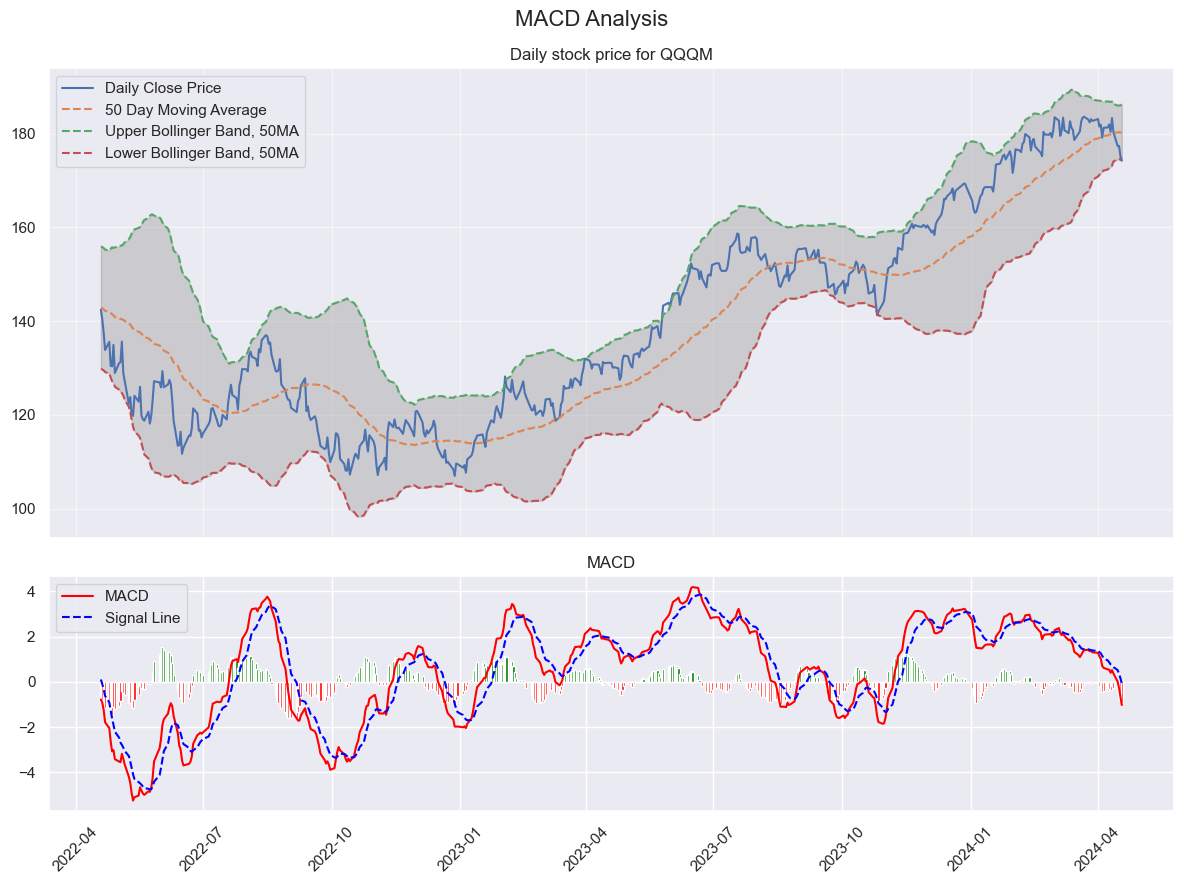

In [6]:
plot_stock('qqqm')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 399.89
Latest 20 Day MA: 411.15
Latest Lower Bollinger Band, 20MA: 395.46
Latest Higher Bollinger Band, 20MA: 426.85
Latest 50 Day MA: 407.91
Latest Lower Bollinger Band, 50MA: 390.13
Latest Higher Bollinger Band, 50MA: 425.69

Latest RSI: 21.2 
Latest MACD Divergence: -2.61 
[*********************100%%**********************]  1 of 1 completed
20MA break point: 411.75
20MA Lower Bollinger Band break point: 394.12
20MA Upper Bollinger Band break point: 429.37
50MA break point: 408.07
50MA Lower Bollinger Band break point: 388.88
50MA Upper Bollinger Band break point: 427.26


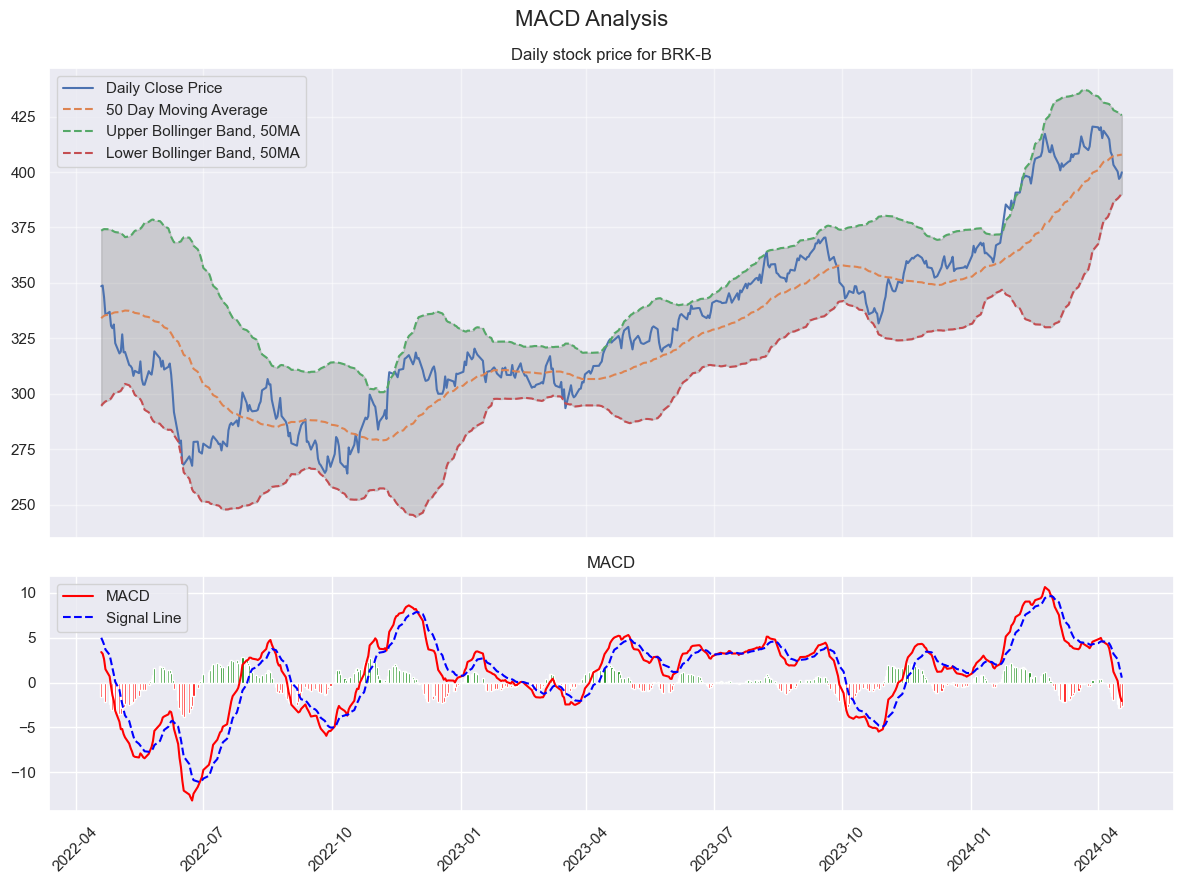

In [7]:
plot_stock('brk-b')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 412.62
Latest 20 Day MA: 423.32
Latest Lower Bollinger Band, 20MA: 403.23
Latest Higher Bollinger Band, 20MA: 443.4
Latest 50 Day MA: 415.45
Latest Lower Bollinger Band, 50MA: 374.93
Latest Higher Bollinger Band, 50MA: 455.97

Latest RSI: 28.68 
Latest MACD Divergence: -2.36 
[*********************100%%**********************]  1 of 1 completed
20MA break point: 423.88
20MA Lower Bollinger Band break point: 400.68
20MA Upper Bollinger Band break point: 447.08
50MA break point: 415.51
50MA Lower Bollinger Band break point: 371.19
50MA Upper Bollinger Band break point: 459.82


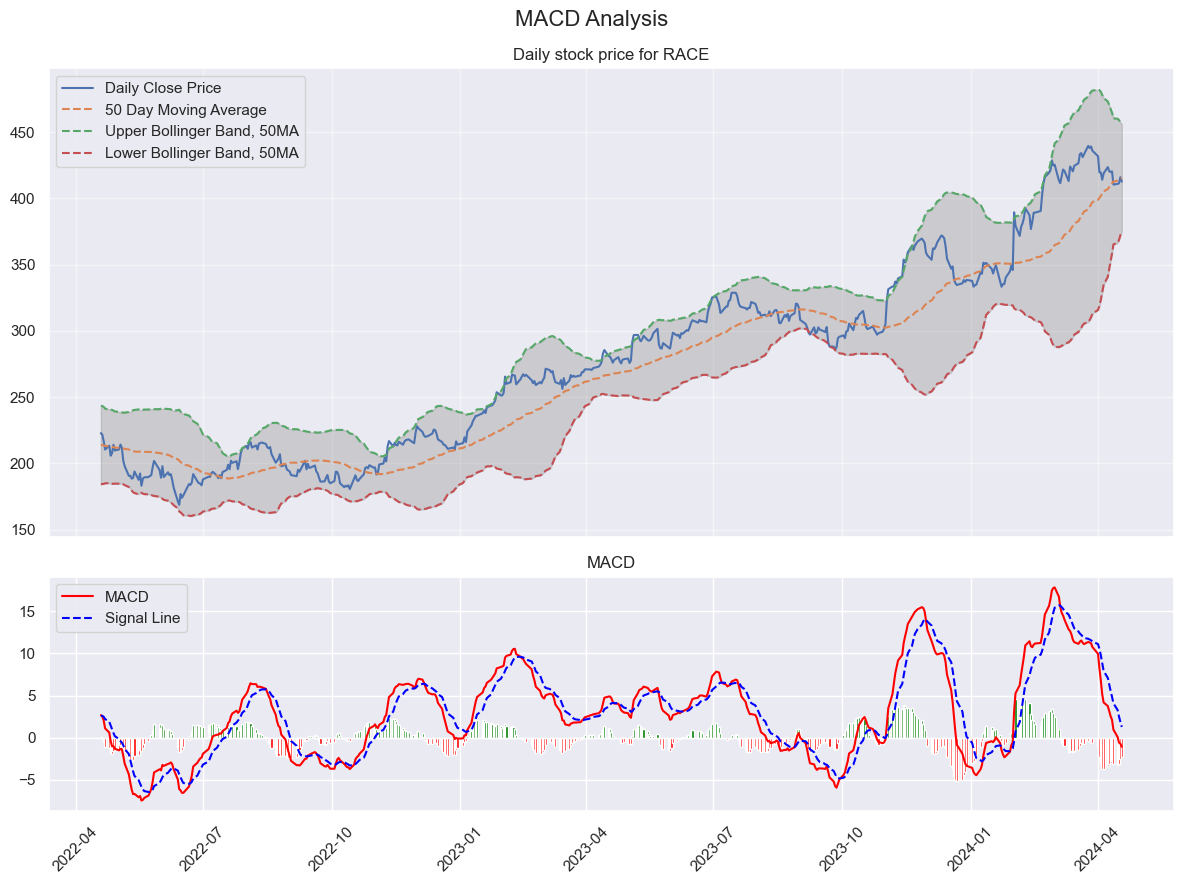

In [8]:
plot_stock('race')

In [9]:
plot_stock('aapl')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 167.04
Latest 20 Day MA: 170.53
Latest Lower Bollinger Band, 20MA: 165.61
Latest Higher Bollinger Band, 20MA: 175.44
Latest 50 Day MA: 175.63
Latest Lower Bollinger Band, 50MA: 159.14
Latest Higher Bollinger Band, 50MA: 192.11

Latest RSI: 41.94 
Latest MACD Divergence: 0.11 
[*********************100%%**********************]  1 of 1 completed
20MA break point: 170.71
20MA Lower Bollinger Band break point: 165.18
20MA Upper Bollinger Band break point: 176.23
50MA break point: 175.8
50MA Lower Bollinger Band break point: 158.08
50MA Upper Bollinger Band break point: 193.52


[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 493.18
Latest 20 Day MA: 469.99
Latest Lower Bollinger Band, 20MA: 430.31
Latest Higher Bollinger Band, 20MA: 509.67
Latest 50 Day MA: 489.44
Latest Lower Bollinger Band, 50MA: 427.81
Latest Higher Bollinger Band, 50MA: 551.08

Latest RSI: 49.37 
Latest MACD Divergence: 3.79 
[*********************100%%**********************]  1 of 1 completed
20MA break point: 468.77
20MA Lower Bollinger Band break point: 423.25
20MA Upper Bollinger Band break point: 514.29
50MA break point: 489.37
50MA Lower Bollinger Band break point: 421.95
50MA Upper Bollinger Band break point: 556.79


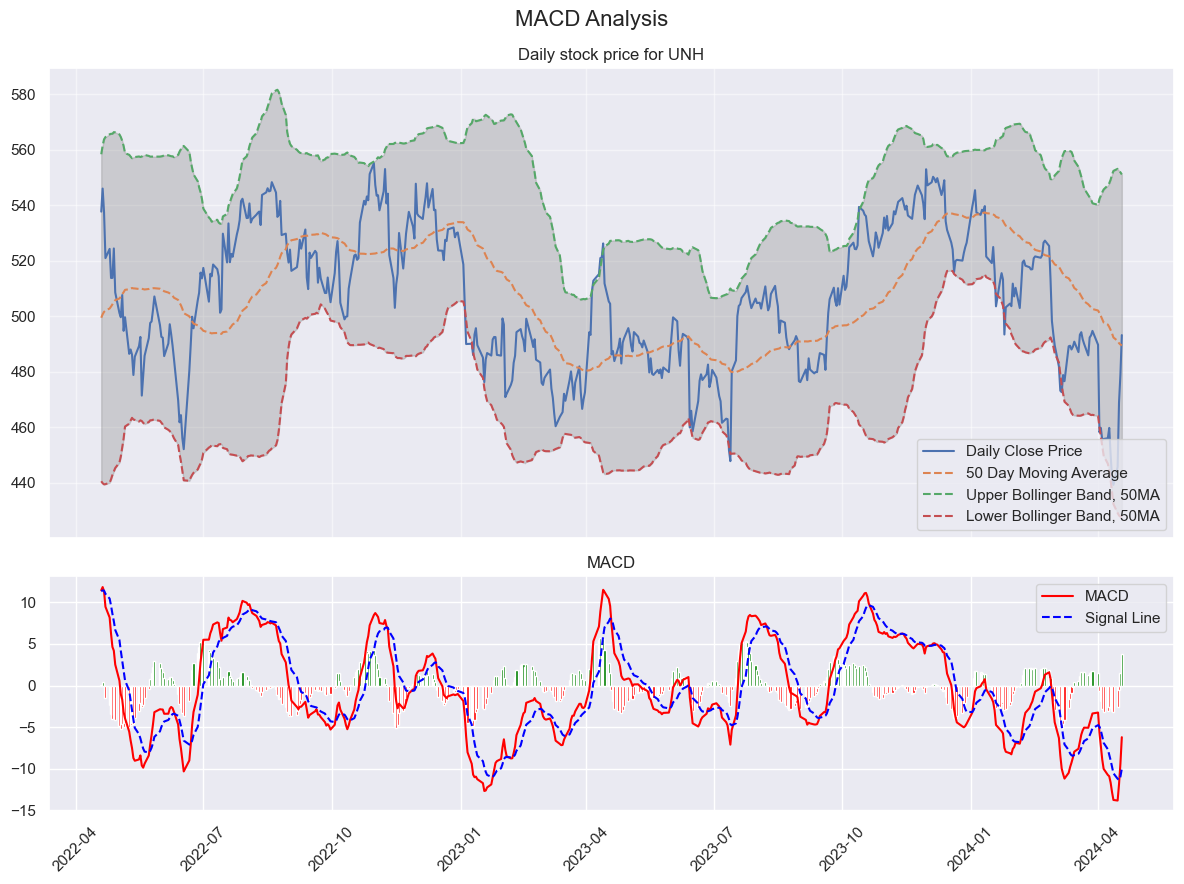

In [10]:
plot_stock('unh')

In [11]:
plot_stock('tsla')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 149.93
Latest 20 Day MA: 169.35
Latest Lower Bollinger Band, 20MA: 153.46
Latest Higher Bollinger Band, 20MA: 185.24
Latest 50 Day MA: 179.47
Latest Lower Bollinger Band, 50MA: 145.99
Latest Higher Bollinger Band, 50MA: 212.96

Latest RSI: 29.94 
Latest MACD Divergence: -1.51 
[*********************100%%**********************]  1 of 1 completed
20MA break point: 170.37
20MA Lower Bollinger Band break point: 154.87
20MA Upper Bollinger Band break point: 185.88
50MA break point: 180.08
50MA Lower Bollinger Band break point: 145.35
50MA Upper Bollinger Band break point: 214.8


[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 711.25
Latest 20 Day MA: 721.91
Latest Lower Bollinger Band, 20MA: 700.26
Latest Higher Bollinger Band, 20MA: 743.56
Latest 50 Day MA: 730.32
Latest Lower Bollinger Band, 50MA: 689.86
Latest Higher Bollinger Band, 50MA: 770.78

Latest RSI: 36.66 
Latest MACD Divergence: -0.64 
[*********************100%%**********************]  1 of 1 completed
20MA break point: 722.47
20MA Lower Bollinger Band break point: 697.34
20MA Upper Bollinger Band break point: 747.6
50MA break point: 730.71
50MA Lower Bollinger Band break point: 687.09
50MA Upper Bollinger Band break point: 774.33


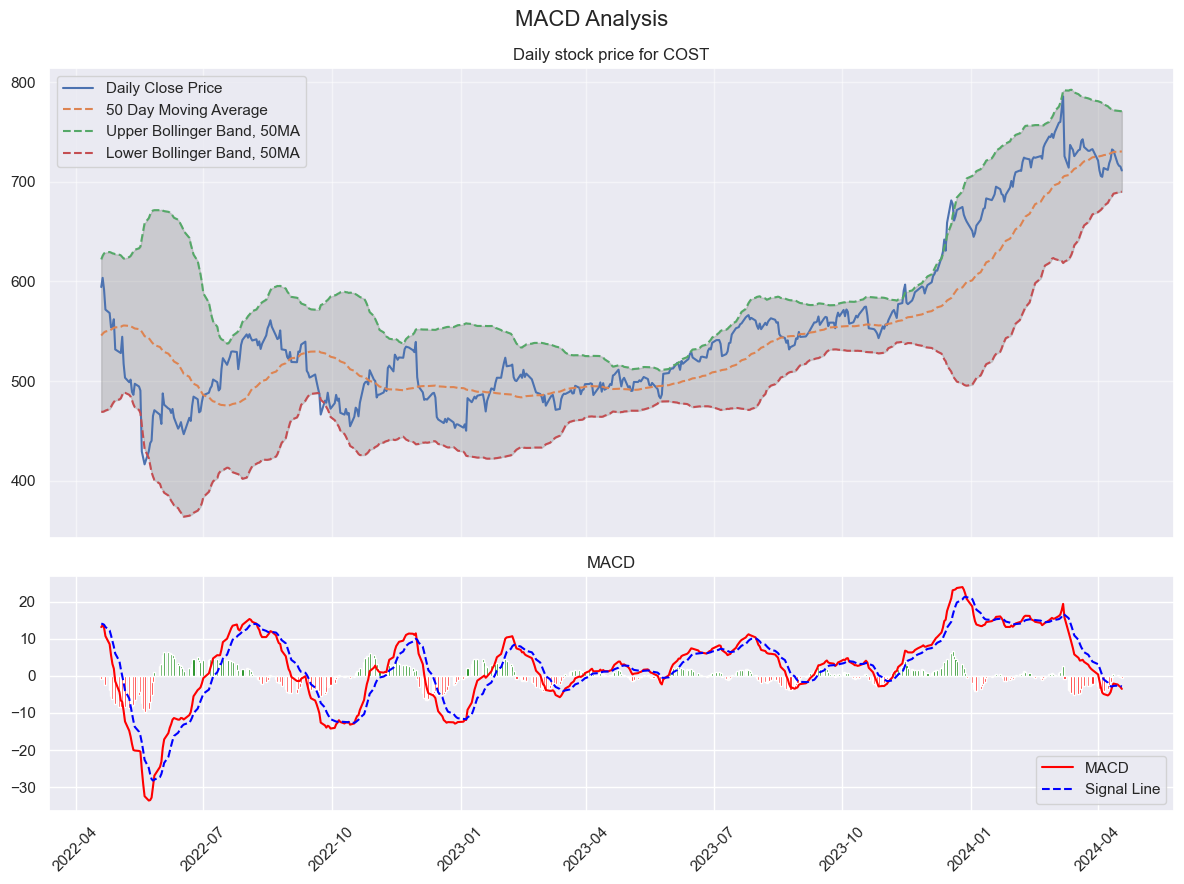

In [12]:
plot_stock('cost')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 112.43
Latest 20 Day MA: 117.49
Latest Lower Bollinger Band, 20MA: 111.19
Latest Higher Bollinger Band, 20MA: 123.8
Latest 50 Day MA: 113.41
Latest Lower Bollinger Band, 50MA: 102.02
Latest Higher Bollinger Band, 50MA: 124.8

Latest RSI: 22.7 
Latest MACD Divergence: -1.16 
[*********************100%%**********************]  1 of 1 completed
20MA break point: 117.76
20MA Lower Bollinger Band break point: 110.79
20MA Upper Bollinger Band break point: 124.73
50MA break point: 113.43
50MA Lower Bollinger Band break point: 100.97
50MA Upper Bollinger Band break point: 125.89


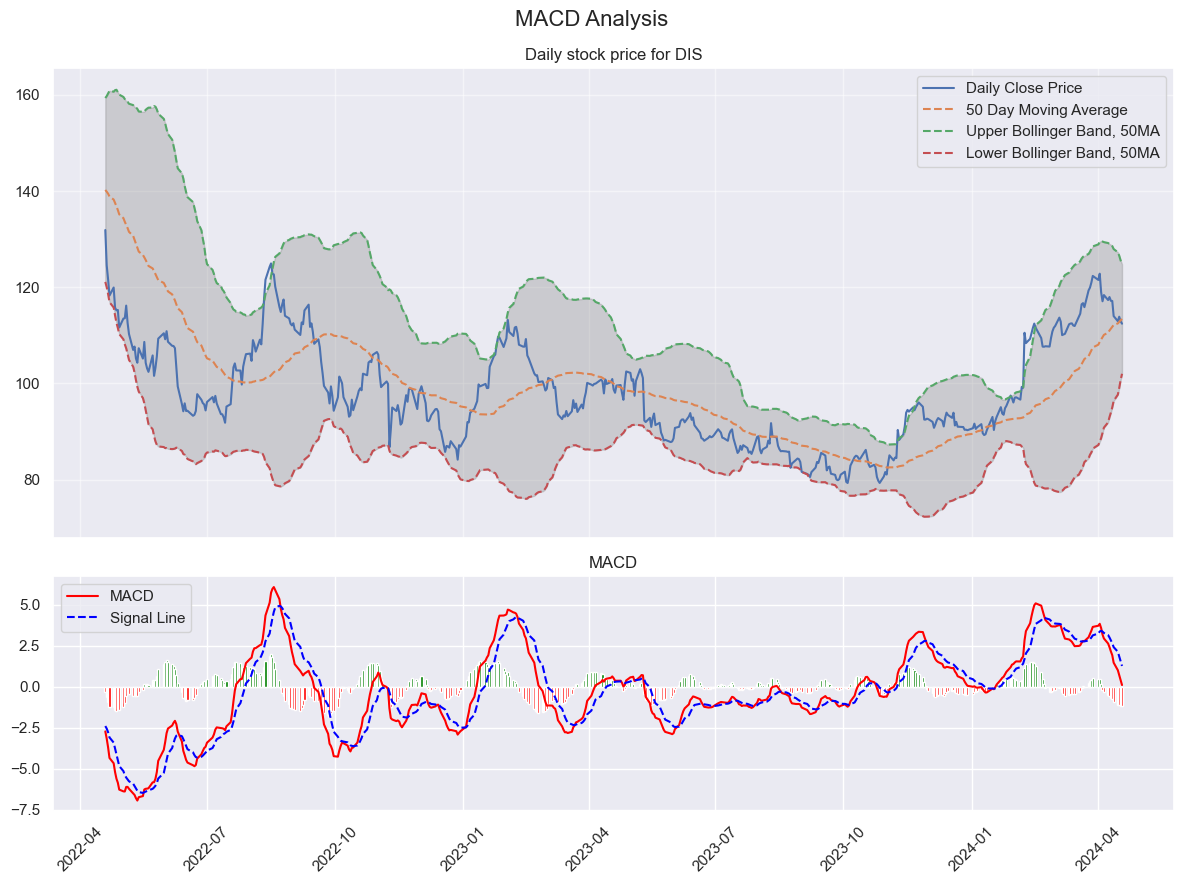

In [13]:
plot_stock('dis')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 141.63
Latest 20 Day MA: 141.95
Latest Lower Bollinger Band, 20MA: 136.06
Latest Higher Bollinger Band, 20MA: 147.85
Latest 50 Day MA: 138.85
Latest Lower Bollinger Band, 50MA: 130.13
Latest Higher Bollinger Band, 50MA: 147.57

Latest RSI: 33.56 
Latest MACD Divergence: -0.71 
[*********************100%%**********************]  1 of 1 completed
20MA break point: 141.97
20MA Lower Bollinger Band break point: 134.94
20MA Upper Bollinger Band break point: 149.01
50MA break point: 138.79
50MA Lower Bollinger Band break point: 129.31
50MA Upper Bollinger Band break point: 148.27


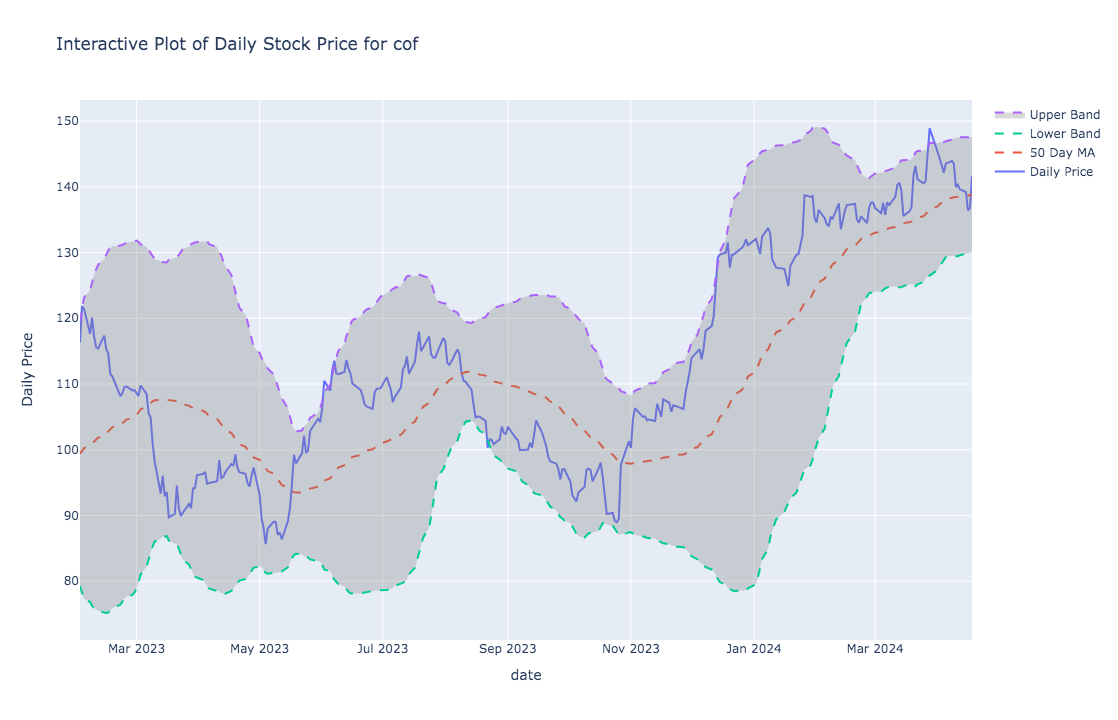

0.02158273381294964
0.014388489208633094


In [14]:
df_cof = plot_stock('cof', start="2022-02-01", return_result=True, interactive=True)
print(df_cof[df_cof['close']>=df_cof['Upper Band - 50MA']].shape[0] / df_cof.shape[0])
print(df_cof[df_cof['close']<=df_cof['Lower Band - 50MA']].shape[0] / df_cof.shape[0])

In [15]:
df_brk = yf.download('brk-b'.upper(),
                 start='2010-01-01',
                 end=datetime.today())
df_brk = df_brk.reset_index()
df_brk['log_price'] = np.log(df_brk['Close'])

df_brk.head()

[*********************100%%**********************]  1 of 1 completed


Date       Open       High        Low      Close  Adj Close   Volume  \
0 2010-01-04  66.000000  66.500000  65.919998  66.220001  66.220001  1575000   
1 2010-01-05  66.389999  66.589996  66.150002  66.540001  66.540001  1310000   
2 2010-01-06  66.500000  66.500000  66.199997  66.199997  66.199997  1760000   
3 2010-01-07  66.199997  66.510002  66.139999  66.459999  66.459999  1505000   
4 2010-01-08  66.480003  66.480003  66.300003  66.440002  66.440002  1500000   

   log_price  
0   4.192983  
1   4.197803  
2   4.192680  
3   4.196600  
4   4.196299

[1.84685] [0.0001381]
Final price extracted: [369.37656554]


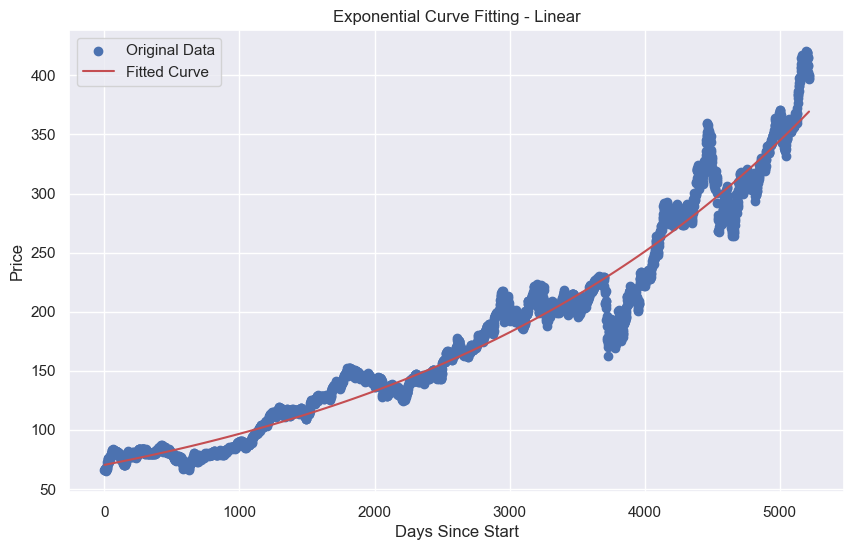

In [16]:
df_sub = df_brk.reset_index()
df_sub['days_since_start'] = (df_sub['Date'] - df_sub['Date'].min()).dt.days

X = df_sub['days_since_start'].values.reshape(-1, 1)  # Feature matrix (date)
y = np.log10(df_sub['Close']).values.reshape(-1, 1)         # Target vector (price)

X_b = np.c_[np.ones((len(X), 1)), X]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

intercept, slope = theta_best[0], theta_best[1]

print(intercept, slope)
print('Final price extracted:',10**(intercept + slope*df_sub.tail(1)['days_since_start'].unique()[0]))

# Generate the fitted curve
days_range = np.linspace(df_sub['days_since_start'].min(), df_sub['days_since_start'].max(), 100)
fitted_curve = 10**(intercept + slope*days_range)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(df_sub['days_since_start'], df_sub['Close'], label='Original Data')
plt.plot(days_range, fitted_curve, 'r-', label='Fitted Curve')
plt.xlabel('Days Since Start')
plt.ylabel('Price')
plt.title('Exponential Curve Fitting - Linear')
plt.legend()
plt.grid(True)
plt.show()


Annual expected return rate:  0.12342164636581665
Final price extracted: 371.0677759810835


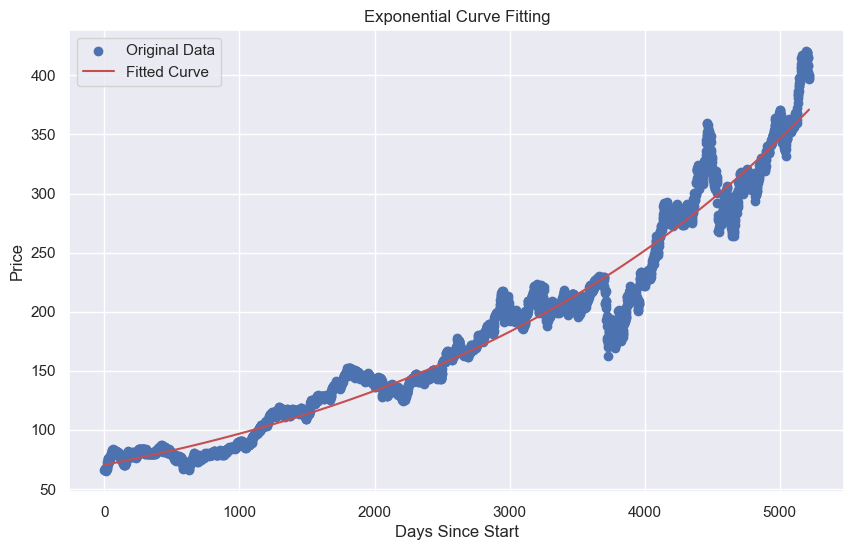

In [17]:
df_sub = df_brk.reset_index()
# df_sub = df_sub[df_sub['Date']>=pd.to_datetime('2010-01-01')]
df_sub['days_since_start'] = (df_sub['Date'] - df_sub['Date'].min()).dt.days

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and contains columns 'days_since_start' and 'Close'

# Define the exponential function
def exponential_func(x, a, b):
    return a * 10**(b * x)

# Initial guess for parameters
initial_guess = (df_sub.head(1)['Close'].unique()[0], np.log10(df_sub.tail(1)['Close'].unique()[0] / df_sub.head(1)['Close'].unique()[0])/df_sub.tail(1)['days_since_start'].unique()[0])  # You might need to adjust these initial values based on your data

# Fit the curve
popt, pcov = curve_fit(exponential_func, df_sub['days_since_start'], df_sub['Close'], p0=initial_guess)

a_fit, b_fit = popt
print('Annual expected return rate: ', 10**(b_fit*365)-1)
print('Final price extracted:',exponential_func(df_sub.tail(1)['days_since_start'].unique()[0],a_fit, b_fit))

# Generate the fitted curve
days_range = np.linspace(df_sub['days_since_start'].min(), df_sub['days_since_start'].max(), 100)
fitted_curve = exponential_func(days_range, *popt)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(df_sub['days_since_start'], df_sub['Close'], label='Original Data')
plt.plot(days_range, fitted_curve, 'r-', label='Fitted Curve')
plt.xlabel('Days Since Start')
plt.ylabel('Price')
plt.title('Exponential Curve Fitting')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%%**********************]  1 of 1 completed
Annual expected return rate:  0.10846414400004445
Final price extracted: 454.4189139091047


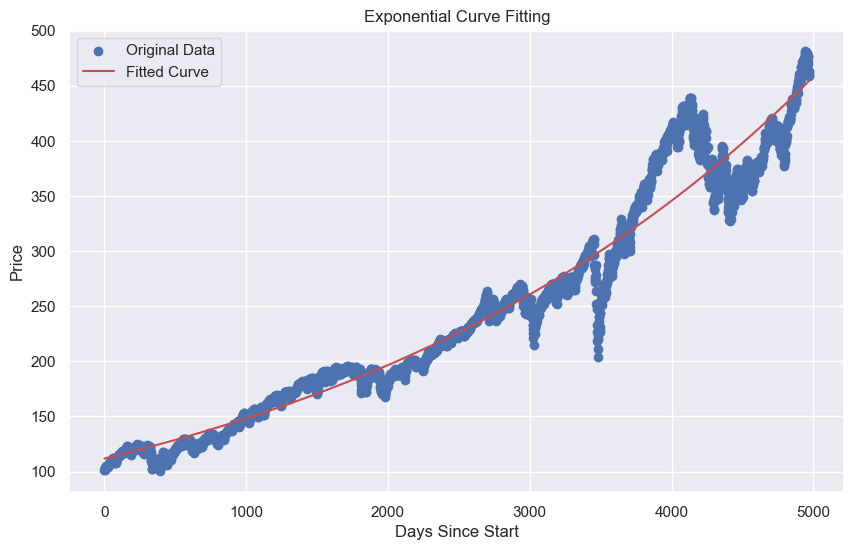

In [18]:
df_voo = yf.download('voo'.upper(),
                 start='2010-01-01',
                 end=datetime.today())
df_voo = df_voo.reset_index()
df_voo['log_price'] = np.log(df_voo['Close'])

df_sub = df_voo[df_voo['Date']>=pd.to_datetime('2010-01-01')]
df_sub['days_since_start'] = (df_sub['Date'] - df_sub['Date'].min()).dt.days

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and contains columns 'days_since_start' and 'Close'

# Define the exponential function
def exponential_func(x, a, b):
    return a * 10**(b * x)

# Initial guess for parameters
initial_guess = (df_sub.head(1)['Close'].unique()[0], np.log10(df_sub.tail(1)['Close'].unique()[0] / df_sub.head(1)['Close'].unique()[0])/df_sub.tail(1)['days_since_start'].unique()[0])  # You might need to adjust these initial values based on your data

# Fit the curve
popt, pcov = curve_fit(exponential_func, df_sub['days_since_start'], df_sub['Close'], p0=initial_guess)

a_fit, b_fit = popt
print('Annual expected return rate: ', 10**(b_fit*365)-1)
print('Final price extracted:',exponential_func(df_sub.tail(1)['days_since_start'].unique()[0],a_fit, b_fit))

# Generate the fitted curve
days_range = np.linspace(df_sub['days_since_start'].min(), df_sub['days_since_start'].max(), 100)
fitted_curve = exponential_func(days_range, *popt)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(df_sub['days_since_start'], df_sub['Close'], label='Original Data')
plt.plot(days_range, fitted_curve, 'r-', label='Fitted Curve')
plt.xlabel('Days Since Start')
plt.ylabel('Price')
plt.title('Exponential Curve Fitting')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
df_qqq = yf.download('qqq'.upper(),
                 start='2010-01-01',
                 end=datetime.today())
df_qqq = df_qqq.reset_index()
df_qqq['log_price'] = np.log(df_qqq['Close'])

df_sub = df_qqq[df_qqq['Date']>=pd.to_datetime('2010-01-01')]
df_sub['days_since_start'] = (df_sub['Date'] - df_sub['Date'].min()).dt.days

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and contains columns 'days_since_start' and 'Close'

# Define the exponential function
def exponential_func(x, a, b):
    return a * 10**(b * x)

# Initial guess for parameters
initial_guess = (df_sub.head(1)['Close'].unique()[0], np.log10(df_sub.tail(1)['Close'].unique()[0] / df_sub.head(1)['Close'].unique()[0])/df_sub.tail(1)['days_since_start'].unique()[0])  # You might need to adjust these initial values based on your data

# Fit the curve
popt, pcov = curve_fit(exponential_func, df_sub['days_since_start'], df_sub['Close'], p0=initial_guess)

a_fit, b_fit = popt
print('Annual expected return rate: ', 10**(b_fit*365)-1)
print('Final price extracted:',exponential_func(df_sub.tail(1)['days_since_start'].unique()[0],a_fit, b_fit))

# Generate the fitted curve
days_range = np.linspace(df_sub['days_since_start'].min(), df_sub['days_since_start'].max(), 100)
fitted_curve = exponential_func(days_range, *popt)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(df_sub['days_since_start'], df_sub['Close'], label='Original Data')
plt.plot(days_range, fitted_curve, 'r-', label='Fitted Curve')
plt.xlabel('Days Since Start')
plt.ylabel('Price')
plt.title('Exponential Curve Fitting')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%%**********************]  1 of 1 completed
Annual expected return rate:  0.16931615163250213
Final price extracted: 429.75193995191864
